In [1]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk.corpus import stopwords
#from nltk import word_tokenize
from nltk.tokenize import word_tokenize
#libraries for lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
#nltk.download('averaged_perceptron_tagger')
#nltk.download('all')

In [2]:
df = pd.read_csv('LTrain.csv')
test_df =pd.read_csv('LTest.csv')

In [3]:
df.head()

,Unnamed: 0,Reviews,Sentiments
0,0,Poor acting: I got this movie as I thought the...,0
1,1,Beware of the movies: This is a wonderful prod...,1
2,2,Did Not Work for TiVo: I have two TiVo Series ...,0
3,3,Sad...: As a mother of three children who were...,0
4,4,Good story: I thought the book was an interest...,1


In [4]:
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
test_df.drop(columns='Unnamed: 0', inplace=True)

In [6]:
df.shape

(30000, 2)

In [7]:
test_df.shape

(5000, 2)

In [8]:
df.head(10)

,Reviews,Sentiments
0,Poor acting: I got this movie as I thought the...,0
1,Beware of the movies: This is a wonderful prod...,1
2,Did Not Work for TiVo: I have two TiVo Series ...,0
3,Sad...: As a mother of three children who were...,0
4,Good story: I thought the book was an interest...,1
5,Defective: This item was shipped on February 6...,0
6,"Spotty performance, useless for iTunes: I purc...",0
7,A Very Good Choice: Even though this game was ...,1
8,Personal Review: I consider this book a creati...,1
9,The Prostate - Everything You Need to Know: Th...,0


In [9]:
#check for imbalance in the labels
balance_check = pd.DataFrame(df['Sentiments'].value_counts().reset_index())
balance_check.columns = ['sentiments', 'frequency']
balance_check['sentiments'] = balance_check['sentiments'].map({1:'positive', 0:'negative'})
balance_check

,sentiments,frequency
0,negative,15000
1,positive,15000


<AxesSubplot:xlabel='Sentiments', ylabel='count'>

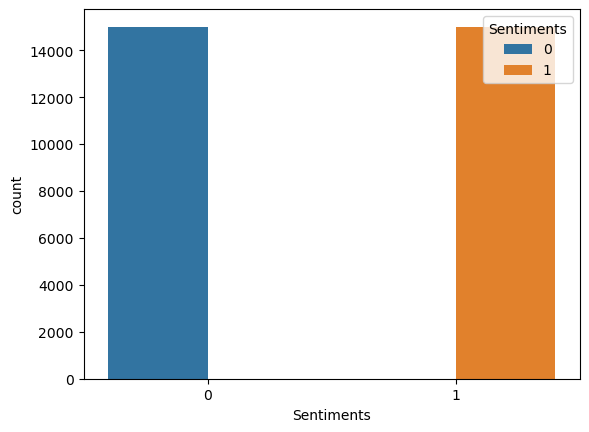

In [10]:
import seaborn as sns
sns.countplot(x=df.Sentiments, hue = df.Sentiments)

In [11]:
import re
def processing(data):
  lt = WordNetLemmatizer()
  corpus = []
  for item in data:
    new_item = re.sub('[^a-zA-Z]',' ',str(item))
    new_item = new_item.lower()
    new_item = new_item.split()
    new_item = [lt.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
    corpus.append(' '.join(str(x) for x in new_item))
  return corpus

In [12]:
import time
tic=time.time()
corpus = processing(df['Reviews'])
toc = time.time()
print(f'The time taken to process the training set is :{(toc-tic)/60}minutes')

The time taken to process the training set is :8.51946162780126minutes


In [13]:
import time
tic=time.time()
test_corpus = processing(test_df.Reviews)
toc = time.time()
print(f'The time taken to process the testing set is :{(toc-tic)/60}minutes')

The time taken to process the testing set is :1.466948926448822minutes


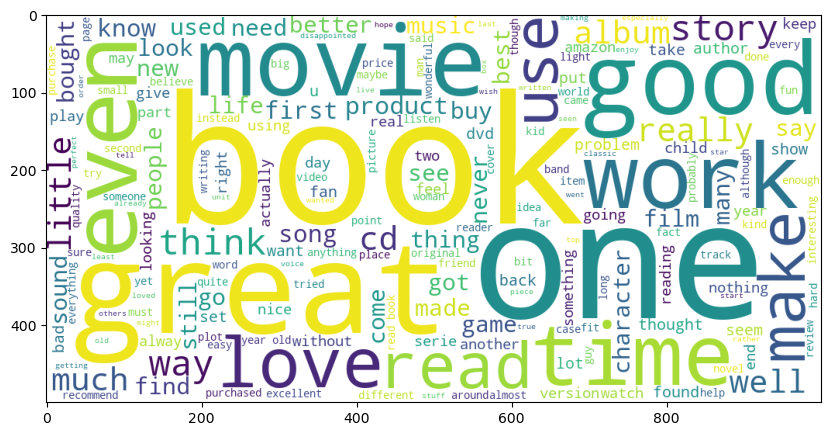

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

In [15]:
# Importing module
from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
 
tfidf = tf_idf(ngram_range=(1,7),
          min_df=3, max_df=0.9, use_idf=1,
          smooth_idf=1, sublinear_tf=1, binary=bool)
#create a function to vectorize input texts
X =corpus
y = df.Sentiments.values

# Splitting the dataset into train and development dataset
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.20, random_state = 0)
np.save('X_train', X_train)
tf_x_train =  tfidf.fit_transform(X_train).toarray()
def transform(data):
  tf_x_train =  tfidf.fit_transform(X_train).toarray()
  vector = tfidf.transform(data).toarray()
  return vector
tf_x_dev = transform(X_dev)
print('done')

done


In [16]:
## Training the Naive Bayes, Logistic Regression, SVM, Random Forest model on the Training set
for i in range(1, 10):
  from sklearn.feature_extraction.text import TfidfVectorizer as tf_idf
 
  tfidf = tf_idf(ngram_range=(1,i),
          min_df=3, max_df=0.9, use_idf=1,
          smooth_idf=1, sublinear_tf=1, binary=bool)
  #create a function to vectorize input texts
  X =corpus
  y = df.Sentiments.values

  # Splitting the dataset into train and development dataset
  from sklearn.model_selection import train_test_split
  X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size = 0.20, random_state = 0)
  np.save('X_train', X_train)
  tf_x_train =  tfidf.fit_transform(X_train).toarray()
  def transform(data):
    tf_x_train =  tfidf.fit_transform(X_train).toarray()
    vector = tfidf.transform(data).toarray()
    return vector
  tf_x_dev = transform(X_dev)
  print('done')
  from sklearn.naive_bayes import GaussianNB
  from sklearn.linear_model import LogisticRegression, SGDClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.svm import LinearSVC
  from sklearn.metrics import accuracy_score, f1_score,  recall_score, precision_score, confusion_matrix

  NB = GaussianNB()
  LR = LogisticRegression(solver='sag', max_iter=1000)
  RF = RandomForestClassifier()
  SG = SGDClassifier(class_weight='balanced', n_jobs=-1)
  LSVM = LinearSVC(class_weight='balanced')
  def compare_models(X_train, X_dev, y_train, y_dev):
    NB.fit(X_train, y_train)
    LR.fit(X_train, y_train)
    RF.fit(X_train, y_train)
    LSVM.fit(X_train, y_train)
    SG.fit(X_train, y_train)

    #predictions from each model
    y_pred_NB = NB.predict(X_dev)
    y_pred_LR = LR.predict(X_dev)
    y_pred_RF = RF.predict(X_dev)
    y_pred_LSVM = LSVM.predict(X_dev)
    y_pred_SG = SG.predict(X_dev) 

    #Model Evaluation 
    pred=[y_pred_NB, y_pred_LR, y_pred_RF, y_pred_LSVM, y_pred_SG]
    accuracy_list=[]
    recall_list = []
    precision_list =[]
    f1_list =[]


    for j in pred:
      #accuracy
      a_score = accuracy_score(y_dev, j)
      accuracy_list.append(a_score)
      #recall
      r_score = recall_score(y_dev, j)
      recall_list.append(r_score)
      #precision
      p_score = precision_score(y_dev, j)
      precision_list.append(p_score)
      #precision
      f_score = f1_score(y_dev, j)
      f1_list.append(f_score)

    #plot a metrics table
    models = ['Naive Bayes', 'Logistic Regression', 'Random Forest Classifier', 'LSVM classifier', 'SGD Classifier']
    metrics_df = pd.DataFrame({'Models':models, 'Accuracy':accuracy_list, 'Recall':recall_list, 'Precision':precision_list, 'F1 score':f1_list})
    return metrics_df
    ## Testing the model on test set
    import time
  tic=time.time()
  models = compare_models(tf_x_train, tf_x_dev, y_train, y_dev)
  toc = time.time()
  print(f'The modelling time is :{(toc-tic)/60}minutes')
  print(models)


done
The modelling time is :6.4517737110455835minutes
                     Models  Accuracy    Recall  Precision  F1 score
0               Naive Bayes  0.685000  0.718110   0.676947  0.696921
1       Logistic Regression  0.871000  0.883344   0.863930  0.873529
2  Random Forest Classifier  0.844167  0.838731   0.850251  0.844452
3           LSVM classifier  0.865333  0.872108   0.862418  0.867236
4            SGD Classifier  0.872500  0.892928   0.859688  0.875993
done
The modelling time is :30.01300196647644minutes
                     Models  Accuracy    Recall  Precision  F1 score
0               Naive Bayes  0.741000  0.779907   0.726601  0.752311
1       Logistic Regression  0.876500  0.888301   0.869621  0.878862
2  Random Forest Classifier  0.847167  0.851289   0.846533  0.848904
3           LSVM classifier  0.882500  0.891937   0.877153  0.884483
4            SGD Classifier  0.880667  0.884005   0.879934  0.881965
done
The modelling time is :43.304187126954396minutes
           

In [19]:
models

,Models,Accuracy,Recall,Precision,F1 score
0,Naive Bayes,0.748500,0.790482,0.732170,0.760210
1,Logistic Regression,0.875833,0.888301,0.868498,0.878288
2,Random Forest Classifier,0.847667,0.845671,0.851297,0.848475
3,LSVM classifier,0.881167,0.891276,0.875365,0.883249
4,SGD Classifier,0.882333,0.890945,0.877604,0.884224


In [20]:
model= SGDClassifier()
model.fit(tf_x_train,y_train)

SGDClassifier()

In [22]:
dev_pred = model.predict(tf_x_dev)
print("Development accuracy :", accuracy_score(y_dev, dev_pred))

Development accuracy : 0.8798333333333334


In [24]:
test_set = tfidf.transform(test_corpus).toarray()
test_pred = model.predict(test_set)
print("Testing accuracy :", accuracy_score(test_df.Sentiments, test_pred))

Testing accuracy : 0.8796


In [28]:
input = [['''I really love this headset!
This is probably the best headset I've had so far because every single feature on it is great!
The audio is impeccable, the sound stays within the headset and not all over the place (which usually happens in most headphones).
The volume wheel is very easy to use and is great to move up and down smoothly.
The cable that connects from your device to the headset is amazing - although a little long for me.
I can't express though how strong and durable the cable is. I have had headsets that have a very weak wire that always breaks after a little while but the wire on this devices looks like it will last a very long time.
Last but not least, the microphone. According to my friends, I sounded much clearer when talking than my previous headsets.
Overall, I really love this headset and I would definetly recommend it! ''']]
process_input = processing(input)
vector_input = tfidf.transform(process_input)
predictions = model.predict(vector_input)
if predictions==1:
  print('Positive Review')
else:
  print('Negative Review')

Positive Review


In [31]:
import cloudpickle as pickle
import dill
import joblib
joblib.dump(model, 'new-model')
np.save('XX_traiN', X_train)
file2 = open('processing_.pkl', 'wb')
file3 = open('fit_tfidf1.pkl', 'wb')
joblib.dump(model, 'new_model')
dill.dump(processing, file2)
dill.dump(transform, file3)
file2.close()
file3.close()